# Model-based clustering for time series

## 0. Packages and imports

### Necessary packages installing and imports
**NB** : It might be necessary to restart the kernel after the installs

In [55]:
pip install pymc==5.18.2
# compatible versions for all pip uninstall pymc pytensor -y 
#pip install pymc==5.1.2 pytensor==2.10.1

SyntaxError: invalid syntax (1444087919.py, line 1)

In [56]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [20]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet, norm
import random
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import ipywidgets
from scipy.signal.windows import gaussian
from tqdm import tqdm
import pickle

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## I. The data

We chose to work with GDP data from the https://www.worldbank.org/ website on time series on the GDP in US$ millions. To do so, we chose several time series (number of countries varying between 55,60, and 71 and time horizon between 1995-2024,1998-2024, and 2000-2024). 
To have interpretable results, we converted the values to growth rate values. 

In the logit structure, that we will see later on, we require an exogeneous variable. For this, we chose to work with poplation size for the time horizon 1995-2024 in 55 countries. 

In [22]:
# N=71, T=25 (2000-2024), normalized between 0 and 1
GDP_25 = pd.read_csv('../Data preprocessing/GDP_yearly_25_colnormalized', index_col=0)
GDP_global_25 = pd.read_csv('../Data preprocessing/GDP_yearly_25_global_normalized')

In [24]:
# Total annual country population, N=55, T=30
pop_30 = pd.read_csv('../Data preprocessing/pop_yearly_30_colnormalized',index_col=0)
pop_global_30 = pd.read_csv('../Data preprocessing/pop_yearly_30_global_normalized')

In [26]:
# Growth rate N=71, T=25(2000-2024)
GDP_25_growth = pd.read_csv('../Data preprocessing/GDP_yearly_25_growth', index_col=0)

# II. The model 

We cant to formulate a time series model for each univariate time series $\mathbb{Y}_i = \{y_{i,1},...,y_{i,T}\}$. 
The model relies on a sampling density for $\mathbb{Y}_i$ which is : 

$p(\mathbb{Y}_i | \theta) = \prod_{t=t_0}^T p(y_{i,t} | \mathbb{Y}_i^{t-1}, \theta ), \text{where } \theta \in \Theta, \mathbb{Y}_i^{t-1} = \{y_{i,1},...,y_{i,t-1} \} $. 

We tried to model the density of $y_{i,t} | \mathbb{Y}_i^{t-1}, \theta$ by several distributions. The first try was with a Gaussian distribution but the results were not concluding. In order to account for the complexity of the model we chose to model it by an $AR(p)$, which gives us the following : 

$y_{i,t} | \mathbb{Y}_i^{t-1}, \theta \sim \mathcal{N}(c + \delta_1 y_{i,t-1} + ... + \delta_p y_{i,t-p}, \sigma^2)$. 

Once the model for $y_{i,t} | \mathbb{Y}_i^{t-1}, \theta$ is chosen, there remains to compute the clustering. The $N$ time series under study are supposed to arise from $K$ groups and we define the latent indicator $S_i = k$ if $\mathbb{Y}_i$ belongs to group $k$ :

$p( \mathbb{Y}_i | S_i, \theta_1, ..., \theta_K) = p( \mathbb{Y}_i | \theta_{S_i}) = \begin{cases}
    p( \mathbb{Y}_i | \theta_1) &\text{ if } S_i = 1 \\
    \vdots \\
    p( \mathbb{Y}_i | \theta_K) &\text{ if } S_i = K
\end{cases}$


The same model is valid in all clusters, but with different parameters $\theta_k$. Also, in this specification the $\mathbb{Y}_i$'s are independent within each cluster. 

We can derive the following joint distribution: 
$p(\mathbb{Y}_1, ..., \mathbb{Y}_N | S_1, ..., S_N, \theta_1, ..., \theta_K) = \prod_{k=1}^K \prod_{i: S_i=k} p(\mathbb{Y}_i | \theta_k)$. 

Our computational work here, beyond computing the clustering method, is to rely on 2 modellings for the probabilistic structure of the groups. Recall the group indicators $\mathbb{S}=(S_1, ..., S_N)$. We assume $S_i$'s are a priori independent and implement here 2 models : 

- Ignorance structure : complete ignorance about the group membership of a certain unit. Hence, $S_i$ has a uniform prior, given by : $\Pr(S_i=k | \eta_1,..., \eta_{K-1}) = \eta_k$, 
where $\eta_k$ is the relative size of group $k$ and $\eta_K = 1- \sum_{k=1}^{K-1} \eta_k$. $(\eta_1,...,\eta_K)$ are unknown model parameters estimated along with the data.

- Logit-type structure : a unit-specific factor might contain information on how to group the time series. This factor could be economic, geographic, or sociopolitical. We can then define a logit-type model for $\Pr(S_i=k)$. For instance, for $K=2$ and a unit-specific exogenous variable $z_i$, we have the following prior for $S_i$: 

$\Pr(S_i=2 | \gamma_1, \gamma_2, z_i) = \frac{\exp (\gamma_1 + z_i \gamma_2)}{1 + \exp(\gamma_1 + z_i \gamma_2)}$ where $(\gamma_1, \gamma_2)$ are unknown parameters to be estimated from the data.



##  II. 1. Determining the adapted ARMA(p, q) model 

To choose the model we will use to model the data, we tried several structure, on the whole panel data (overall pooling). We focus on models like $AR(1)$ and $AR(2)$ with and without constants. 

### Normalized series

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


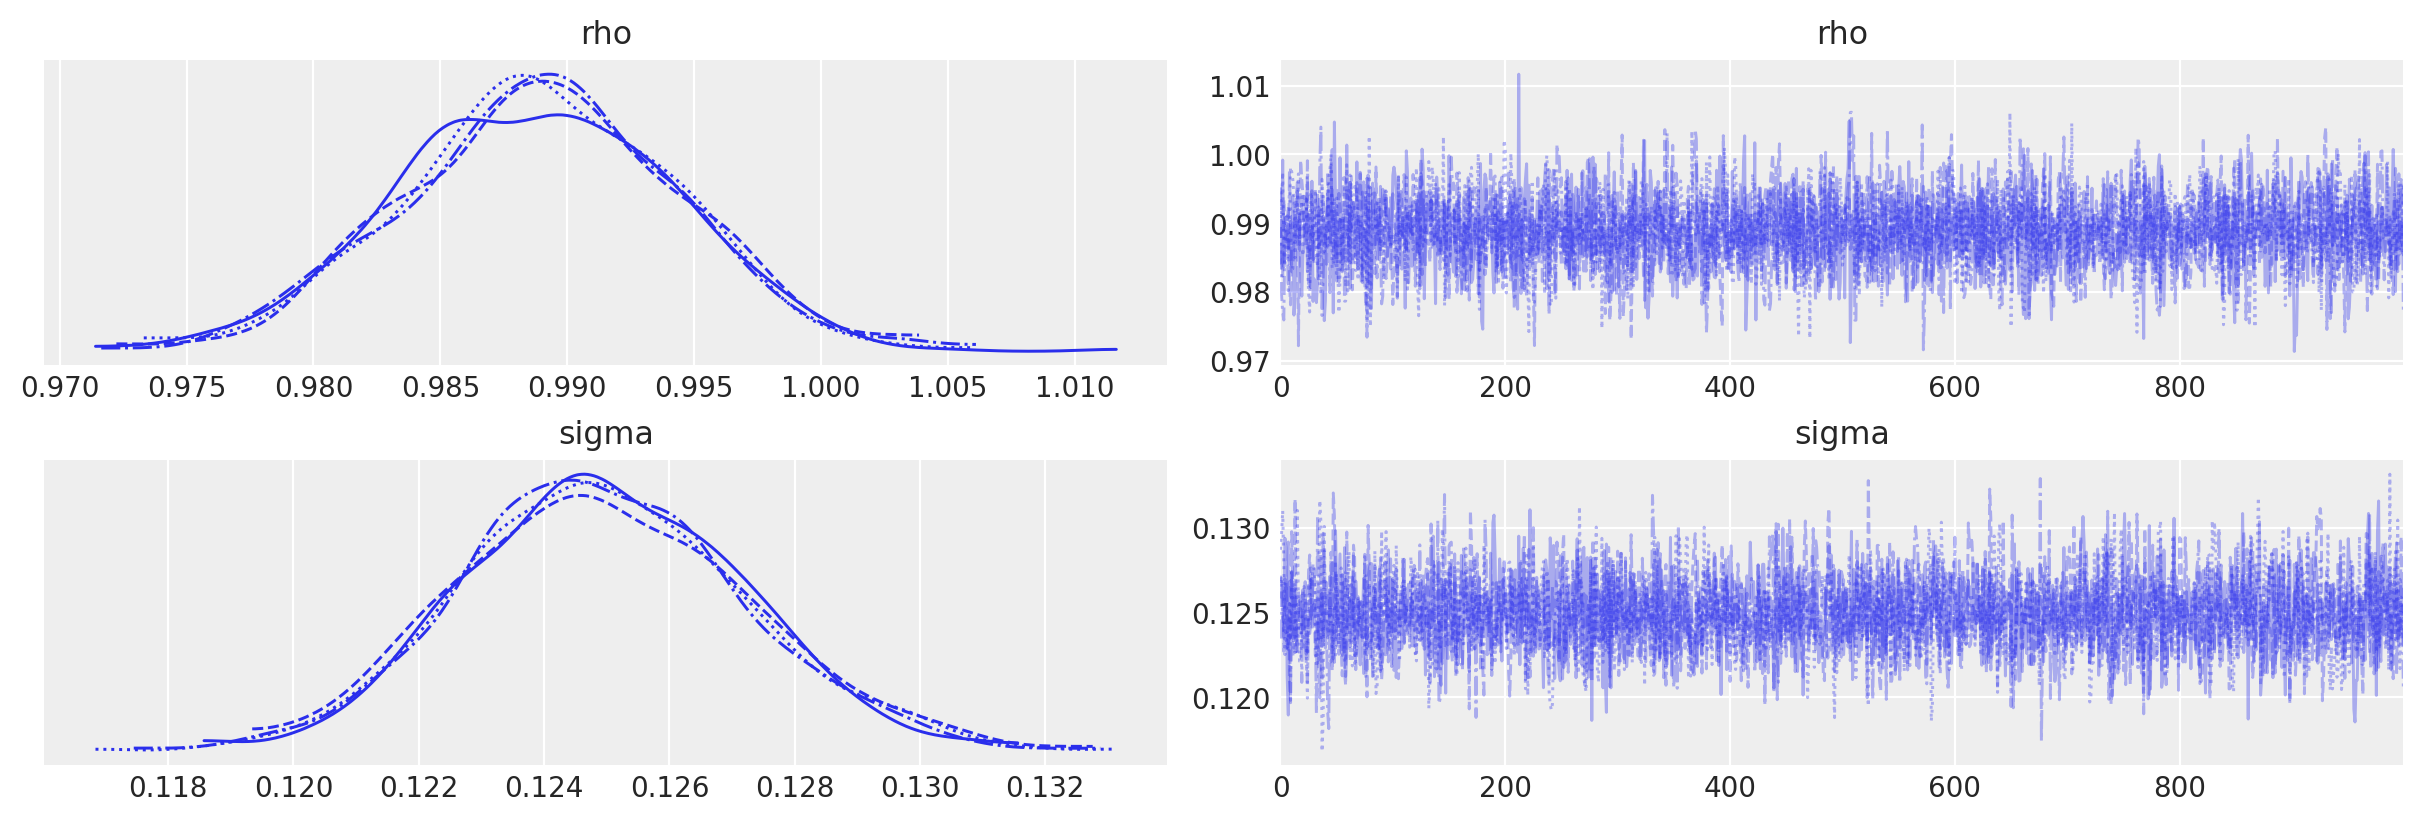

In [69]:
# AR(1) no constant
y = GDP_25.T # NB : il faut que les pays soient en lignes (df NxT)

with pm.Model() as ar1nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=1)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar1nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar1nc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar1nc.extend(pm.compute_log_likelihood(idata_ar1nc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)

az.plot_trace(
    idata_ar1nc
);

In [70]:
idata_ar1nc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [71]:
# Statistics
az.summary(idata_ar1nc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.989  0.005   0.979    0.999        0.0      0.0    4056.0    2810.0   
sigma   0.125  0.002   0.121    0.129        0.0      0.0    3884.0    2732.0   

        r_hat  
rho[0]    1.0  
sigma     1.0

In [72]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar1nc.log_likelihood.ar1nc.sum(["ar1nc_dim_0"]).mean(["chain","draw"]).values

array(830.07223137)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


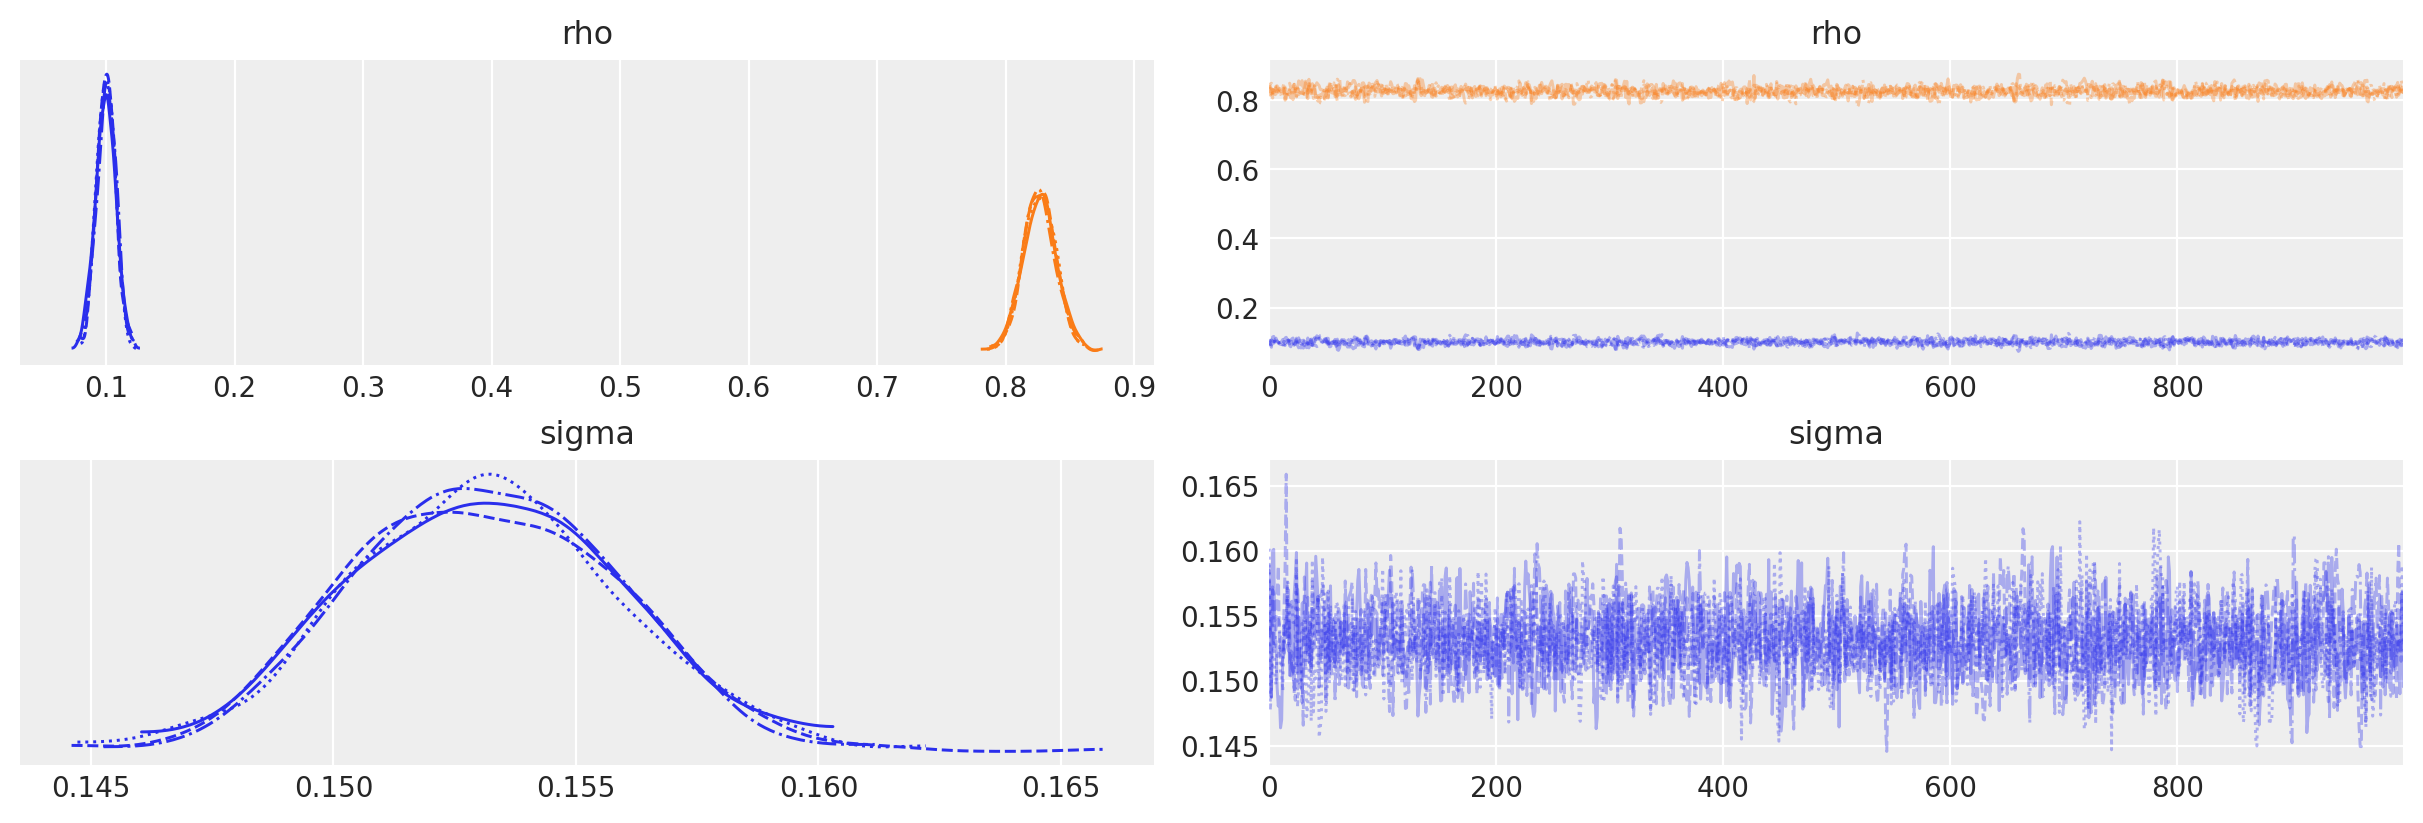

In [73]:
# AR(1) with constant
y = GDP_25.T

with pm.Model() as ar1wc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar1wc", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar1wc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar1wc.extend(pm.compute_log_likelihood(idata_ar1wc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)

az.plot_trace(
    idata_ar1wc
);

In [74]:
# Stats des coefs
az.summary(idata_ar1wc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.100  0.008   0.086    0.114        0.0      0.0    1508.0    1533.0   
rho[1]  0.826  0.013   0.804    0.851        0.0      0.0    1480.0    1509.0   
sigma   0.153  0.003   0.148    0.158        0.0      0.0    2304.0    1826.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
sigma     1.0

In [75]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar1wc.log_likelihood.ar1wc.sum(["ar1wc_dim_0"]).mean(["chain","draw"]).values

array(521.87673313)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.


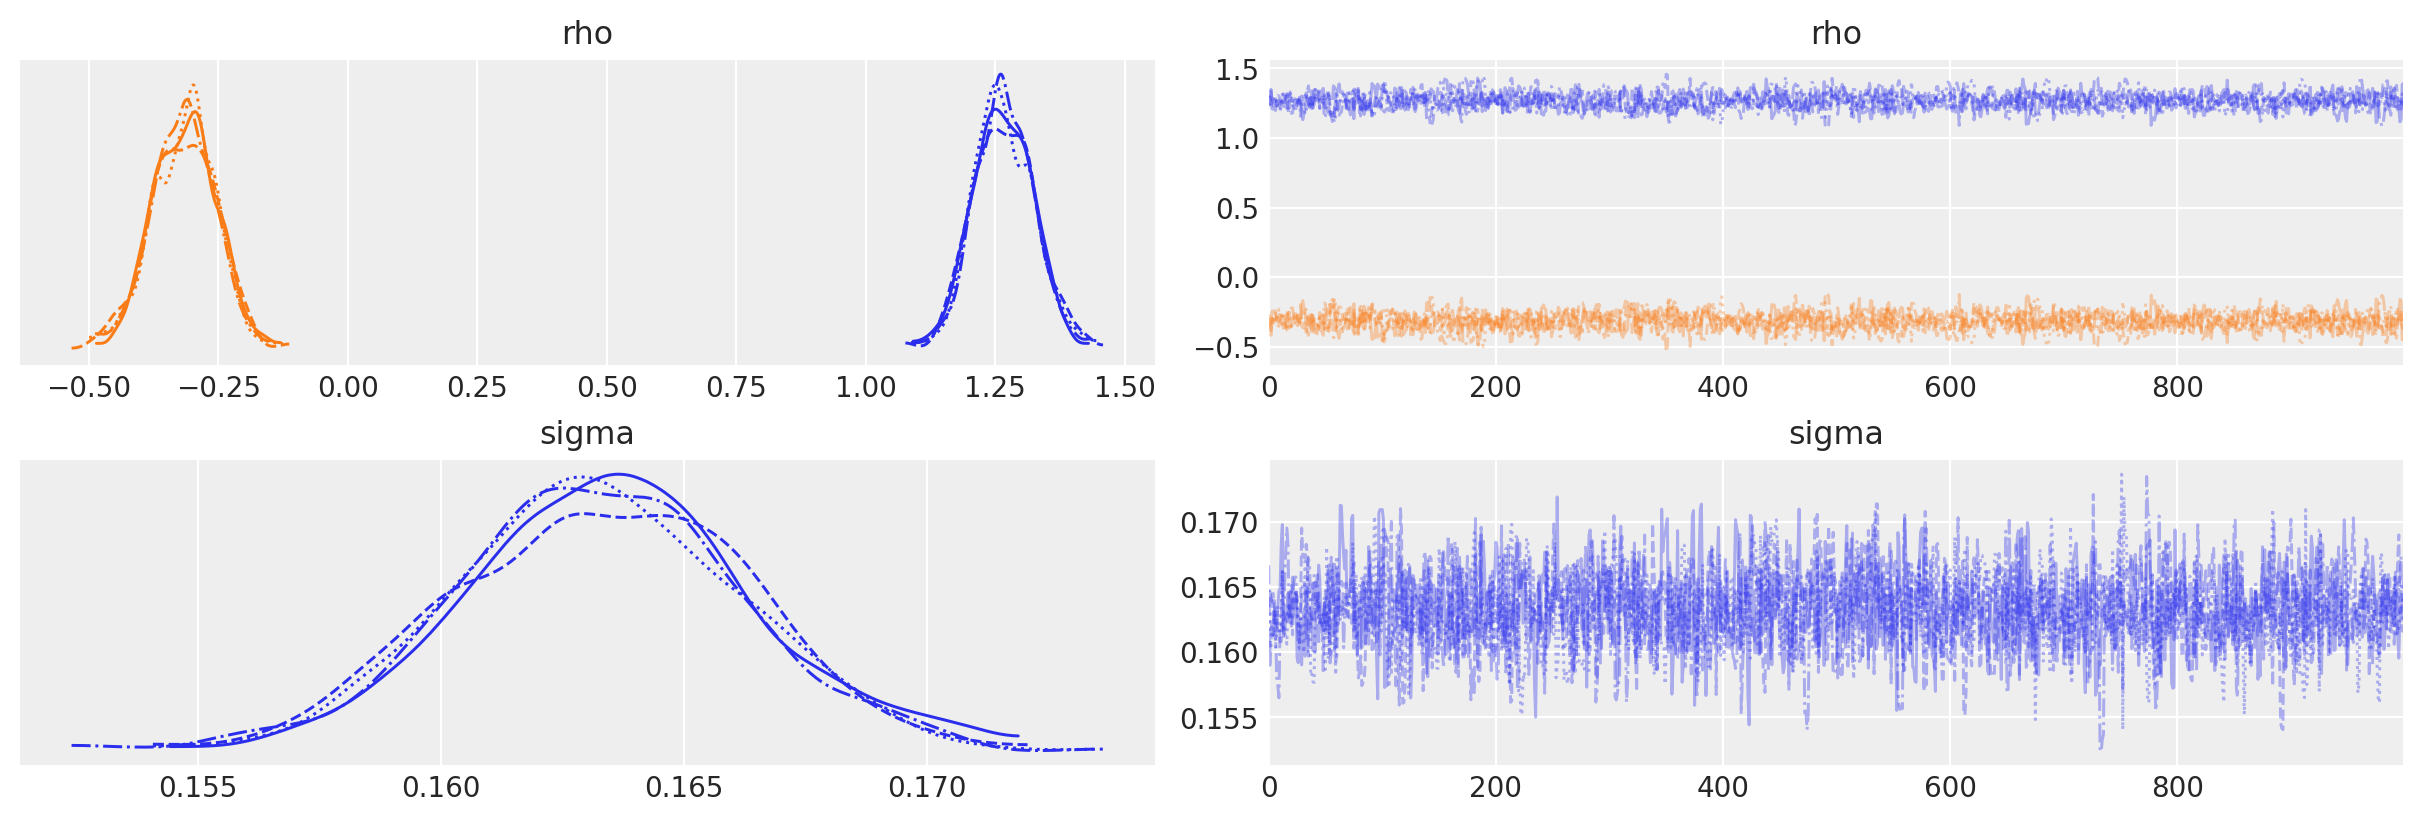

In [76]:
# AR(2) no constant
y = GDP_25.T

with pm.Model() as ar2nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar2nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar2nc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )
    
    idata_ar2nc.extend(pm.compute_log_likelihood(idata_ar2nc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)
    
az.plot_trace(
    idata_ar2nc
);

In [77]:
# Stats des coefs
az.summary(idata_ar2nc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  1.266  0.059   1.162    1.382      0.002    0.001    1212.0    1329.0   
rho[1] -0.316  0.063  -0.431   -0.194      0.002    0.001    1198.0    1308.0   
sigma   0.163  0.003   0.158    0.169      0.000    0.000    1993.0    1761.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
sigma     1.0

In [78]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar2nc.log_likelihood.ar2nc.sum(["ar2nc_dim_0"]).mean(["chain","draw"]).values

array(175.77263344)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 6 seconds.


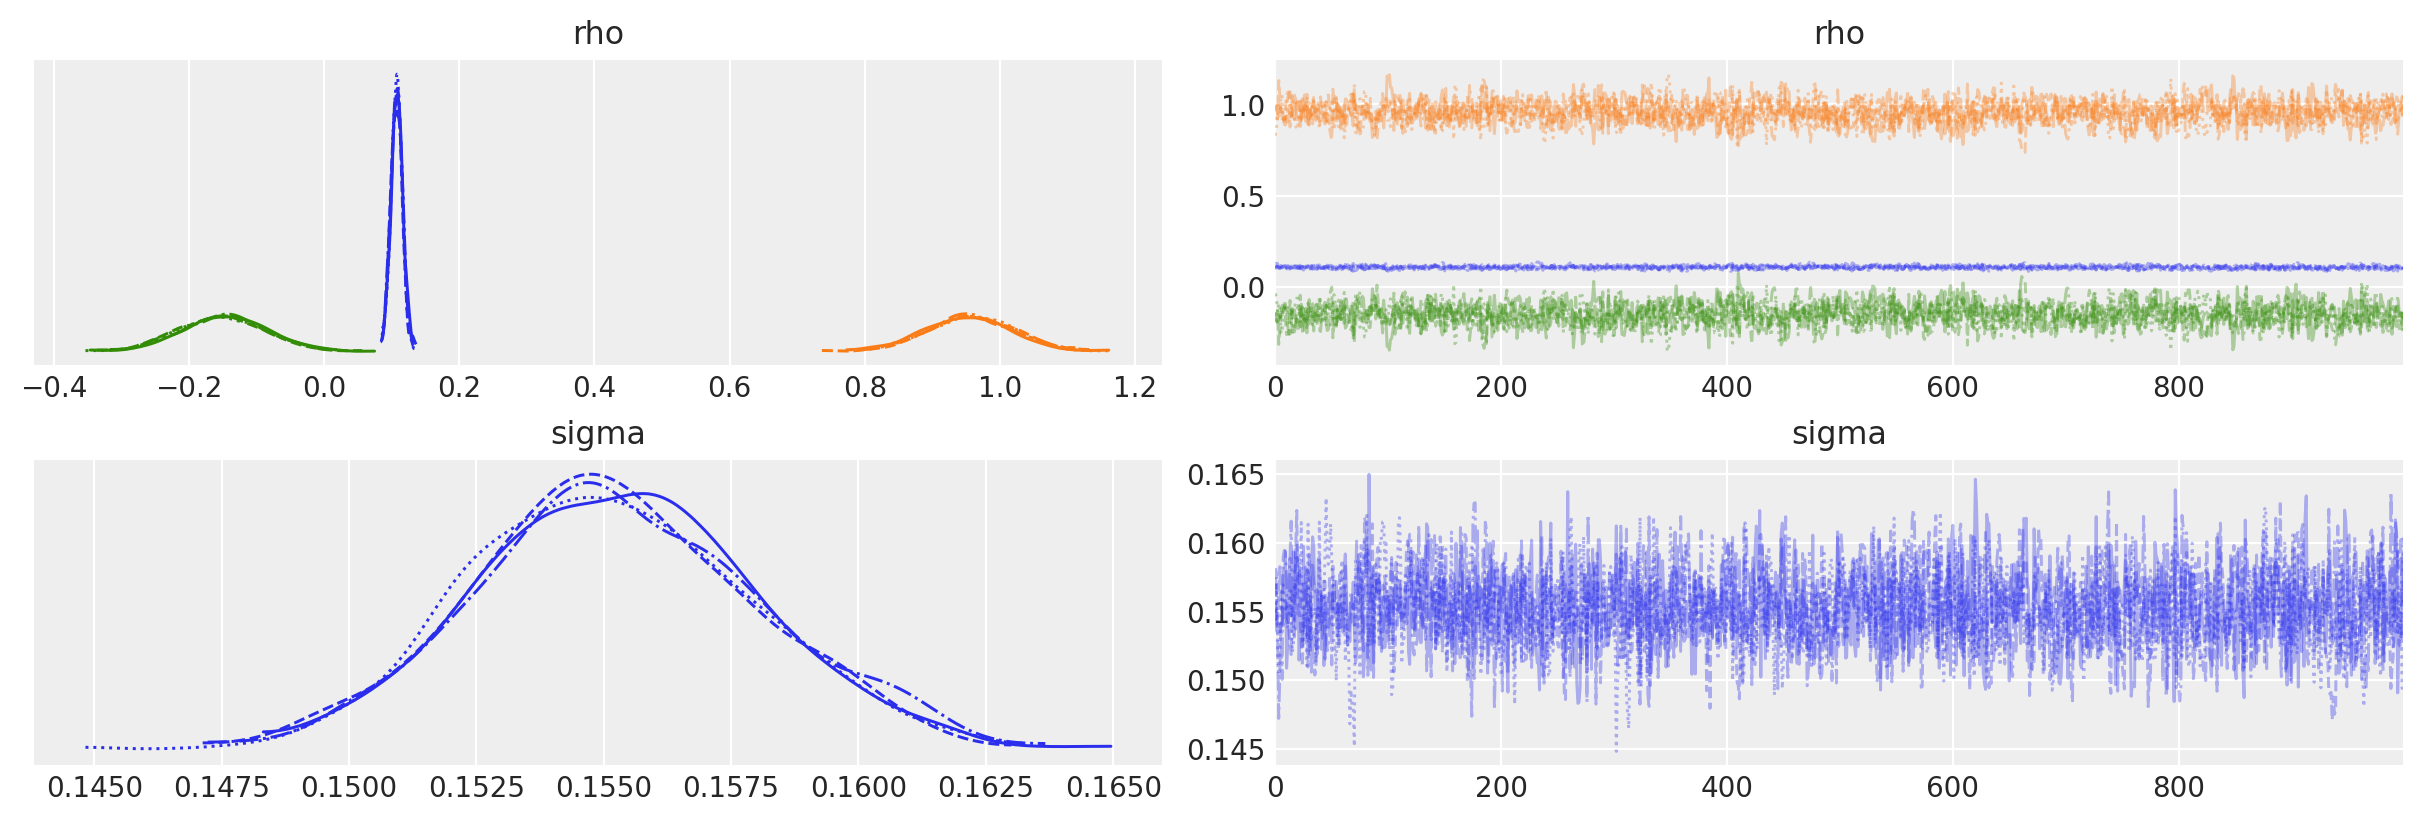

In [79]:
# AR(2) with constant
y = GDP_25.T

with pm.Model() as ar2wc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=3)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar2wc", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar2wc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar2wc.extend(pm.compute_log_likelihood(idata_ar2wc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)
    
az.plot_trace(
    idata_ar2wc
);

In [80]:
# Stats des coefs
az.summary(idata_ar2wc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.108  0.008   0.091    0.122      0.000    0.000    2031.0    2124.0   
rho[1]  0.956  0.063   0.832    1.067      0.002    0.001    1427.0    1607.0   
rho[2] -0.150  0.062  -0.263   -0.034      0.002    0.001    1498.0    1841.0   
sigma   0.155  0.003   0.150    0.161      0.000    0.000    2304.0    2221.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
rho[2]    1.0  
sigma     1.0

In [81]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar2wc.log_likelihood.ar2wc.sum(["ar2wc_dim_0"]).mean(["chain","draw"]).values

array(252.99122621)

### Growth series

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


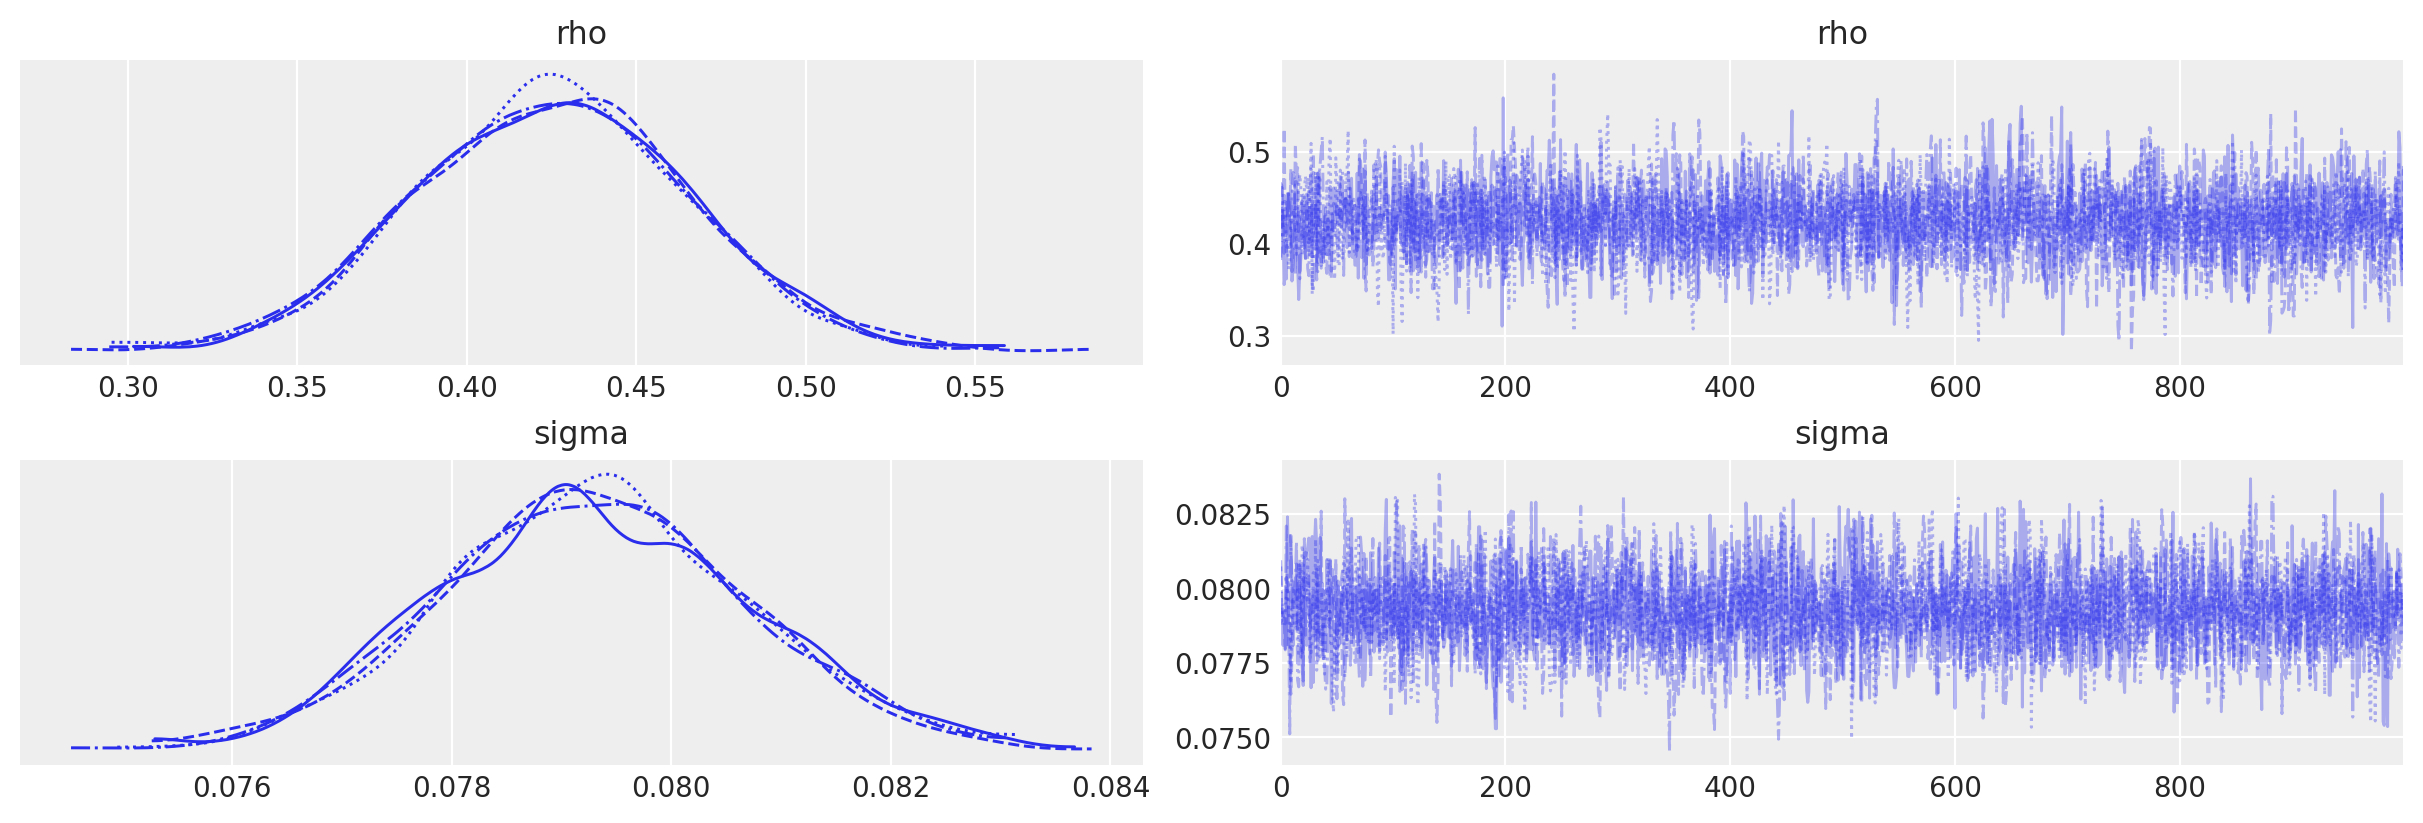

In [94]:
# AR(1) no constant
y = GDP_25_growth.T # NB : il faut que les pays soient en lignes (df NxT)

with pm.Model() as ar1nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=1)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar1nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar1nc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar1nc.extend(pm.compute_log_likelihood(idata_ar1nc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)

az.plot_trace(
    idata_ar1nc
);

In [95]:
# Stats des coefs
az.summary(idata_ar1nc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.425  0.040   0.351    0.500      0.001      0.0    3470.0    2676.0   
sigma   0.079  0.001   0.077    0.082      0.000      0.0    3757.0    2725.0   

        r_hat  
rho[0]    1.0  
sigma     1.0

In [96]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar1nc.log_likelihood.ar1nc.sum(["ar1nc_dim_0"]).mean(["chain","draw"]).values

array(1594.13887645)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


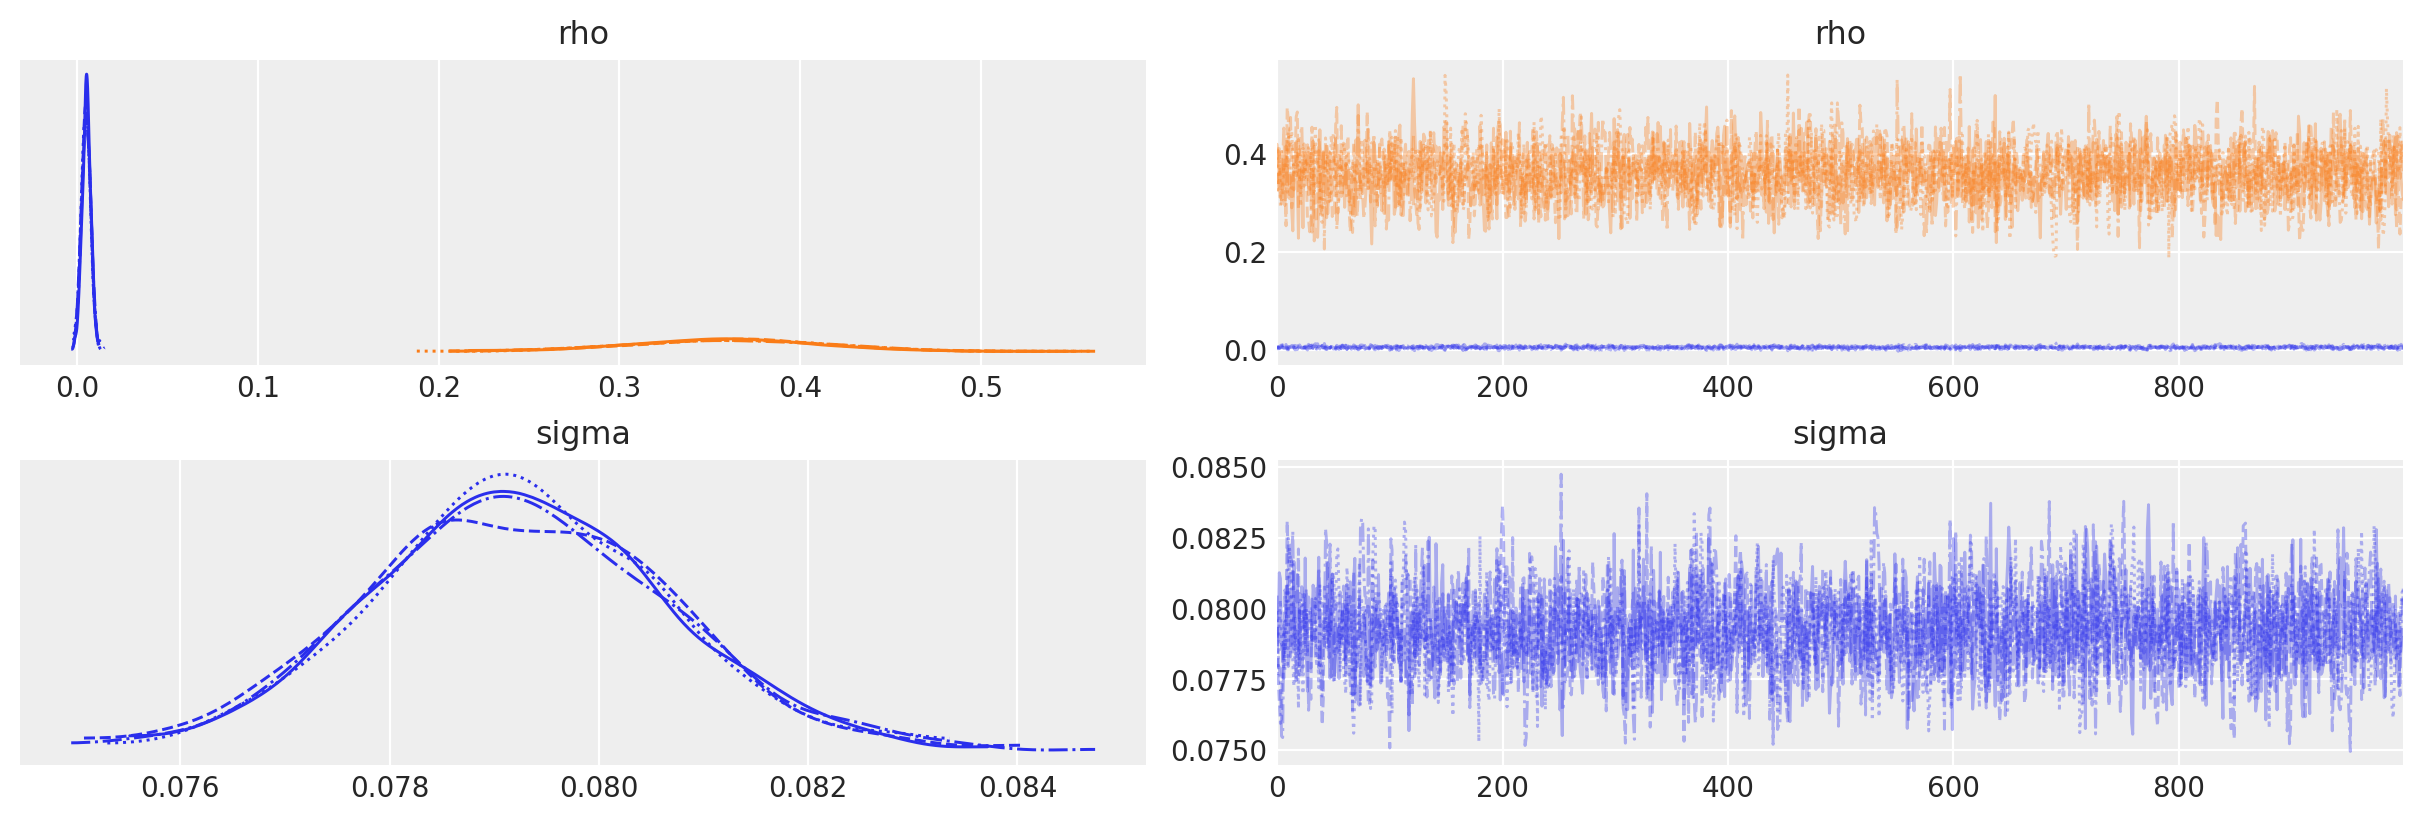

In [97]:
# AR(1) with constant
y = GDP_25_growth.T

with pm.Model() as ar1wc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar1wc", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar1wc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar1wc.extend(pm.compute_log_likelihood(idata_ar1wc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)

az.plot_trace(
    idata_ar1wc
);

In [98]:
# Stats des coefs
az.summary(idata_ar1wc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.005  0.003   0.000    0.010      0.000    0.000    2390.0    2830.0   
rho[1]  0.360  0.053   0.265    0.460      0.001    0.001    2524.0    2516.0   
sigma   0.079  0.001   0.076    0.082      0.000    0.000    2588.0    2673.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
sigma     1.0

In [99]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar1wc.log_likelihood.ar1wc.sum(["ar1wc_dim_0"]).mean(["chain","draw"]).values

array(1595.52176132)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


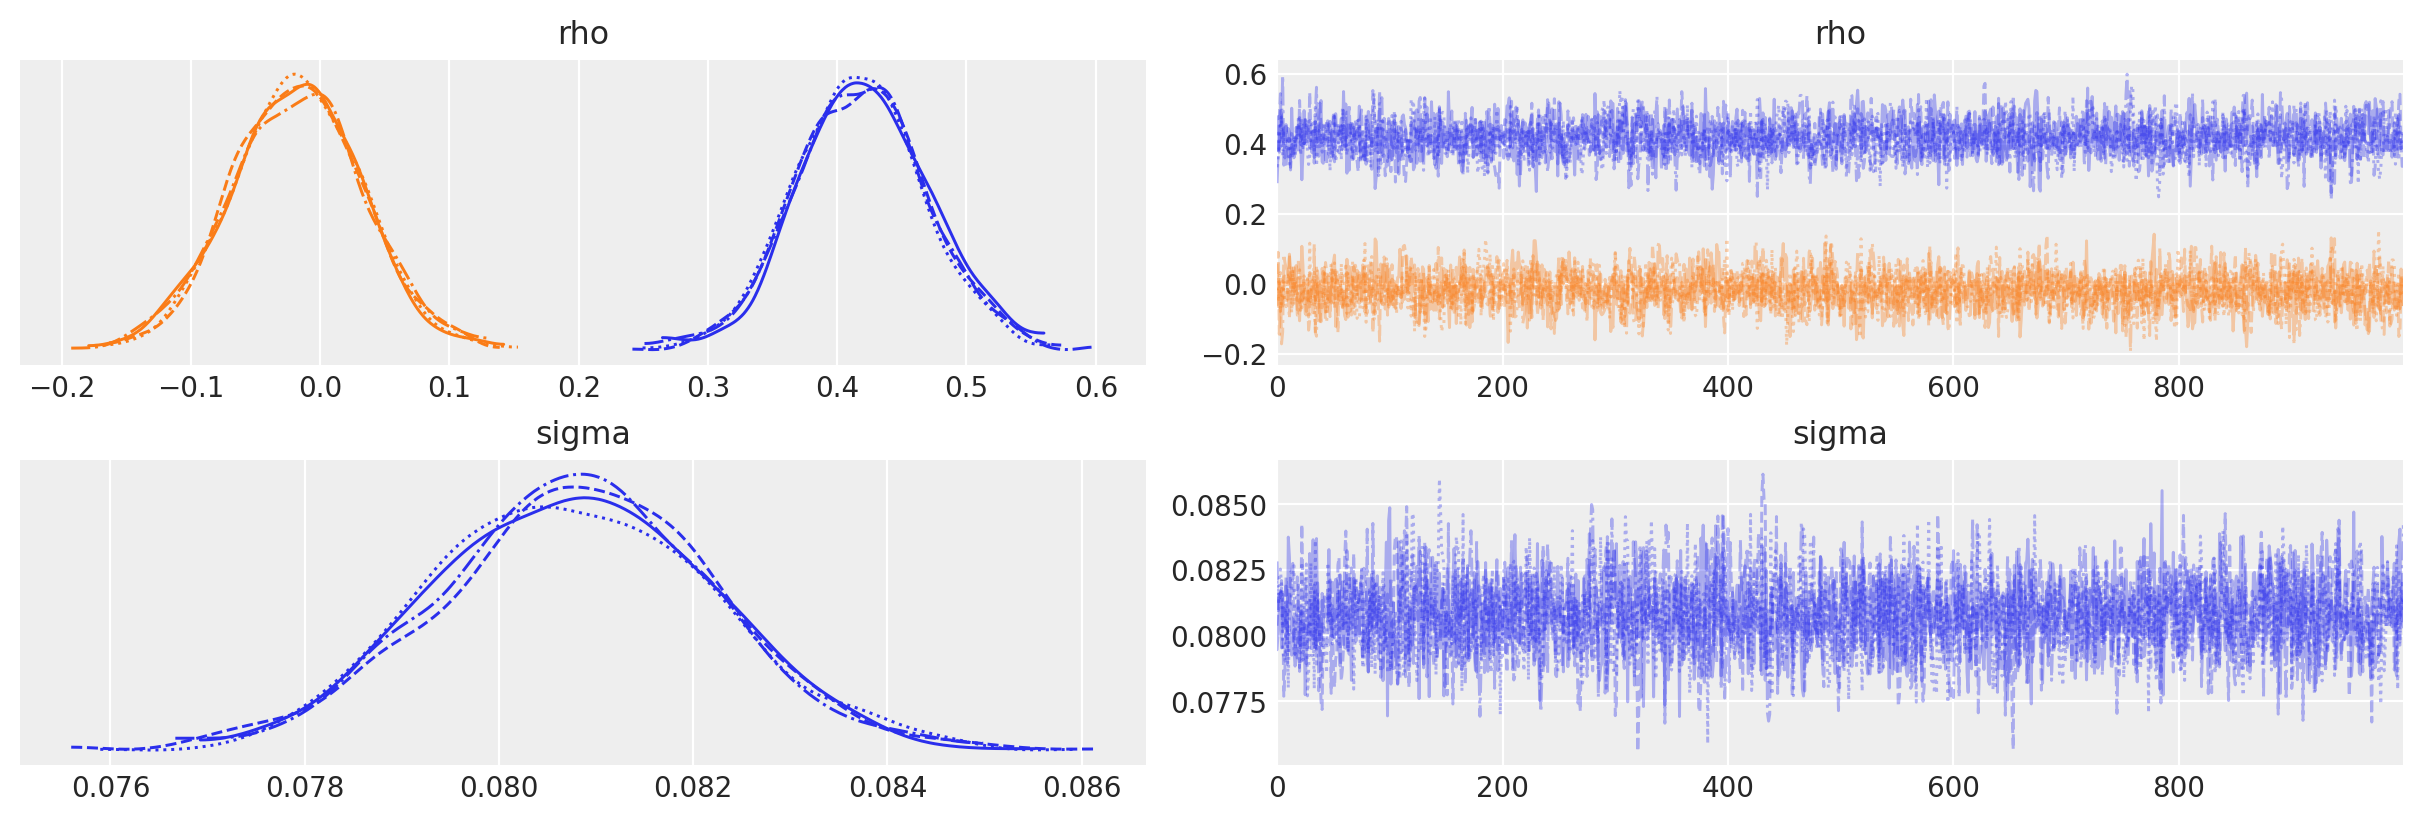

In [100]:
# AR(2) no constant
y = GDP_25_growth.T

with pm.Model() as ar2nc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar2nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar2nc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )
    
    idata_ar2nc.extend(pm.compute_log_likelihood(idata_ar2nc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)
    
az.plot_trace(
    idata_ar2nc
);

In [101]:
# Stats des coefs
az.summary(idata_ar2nc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.419  0.051   0.331    0.523      0.001    0.001    2681.0    2735.0   
rho[1] -0.018  0.051  -0.118    0.074      0.001    0.001    2603.0    2546.0   
sigma   0.081  0.001   0.078    0.084      0.000    0.000    2989.0    2483.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
sigma     1.0

In [102]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar2nc.log_likelihood.ar2nc.sum(["ar2nc_dim_0"]).mean(["chain","draw"]).values

array(1257.21600983)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


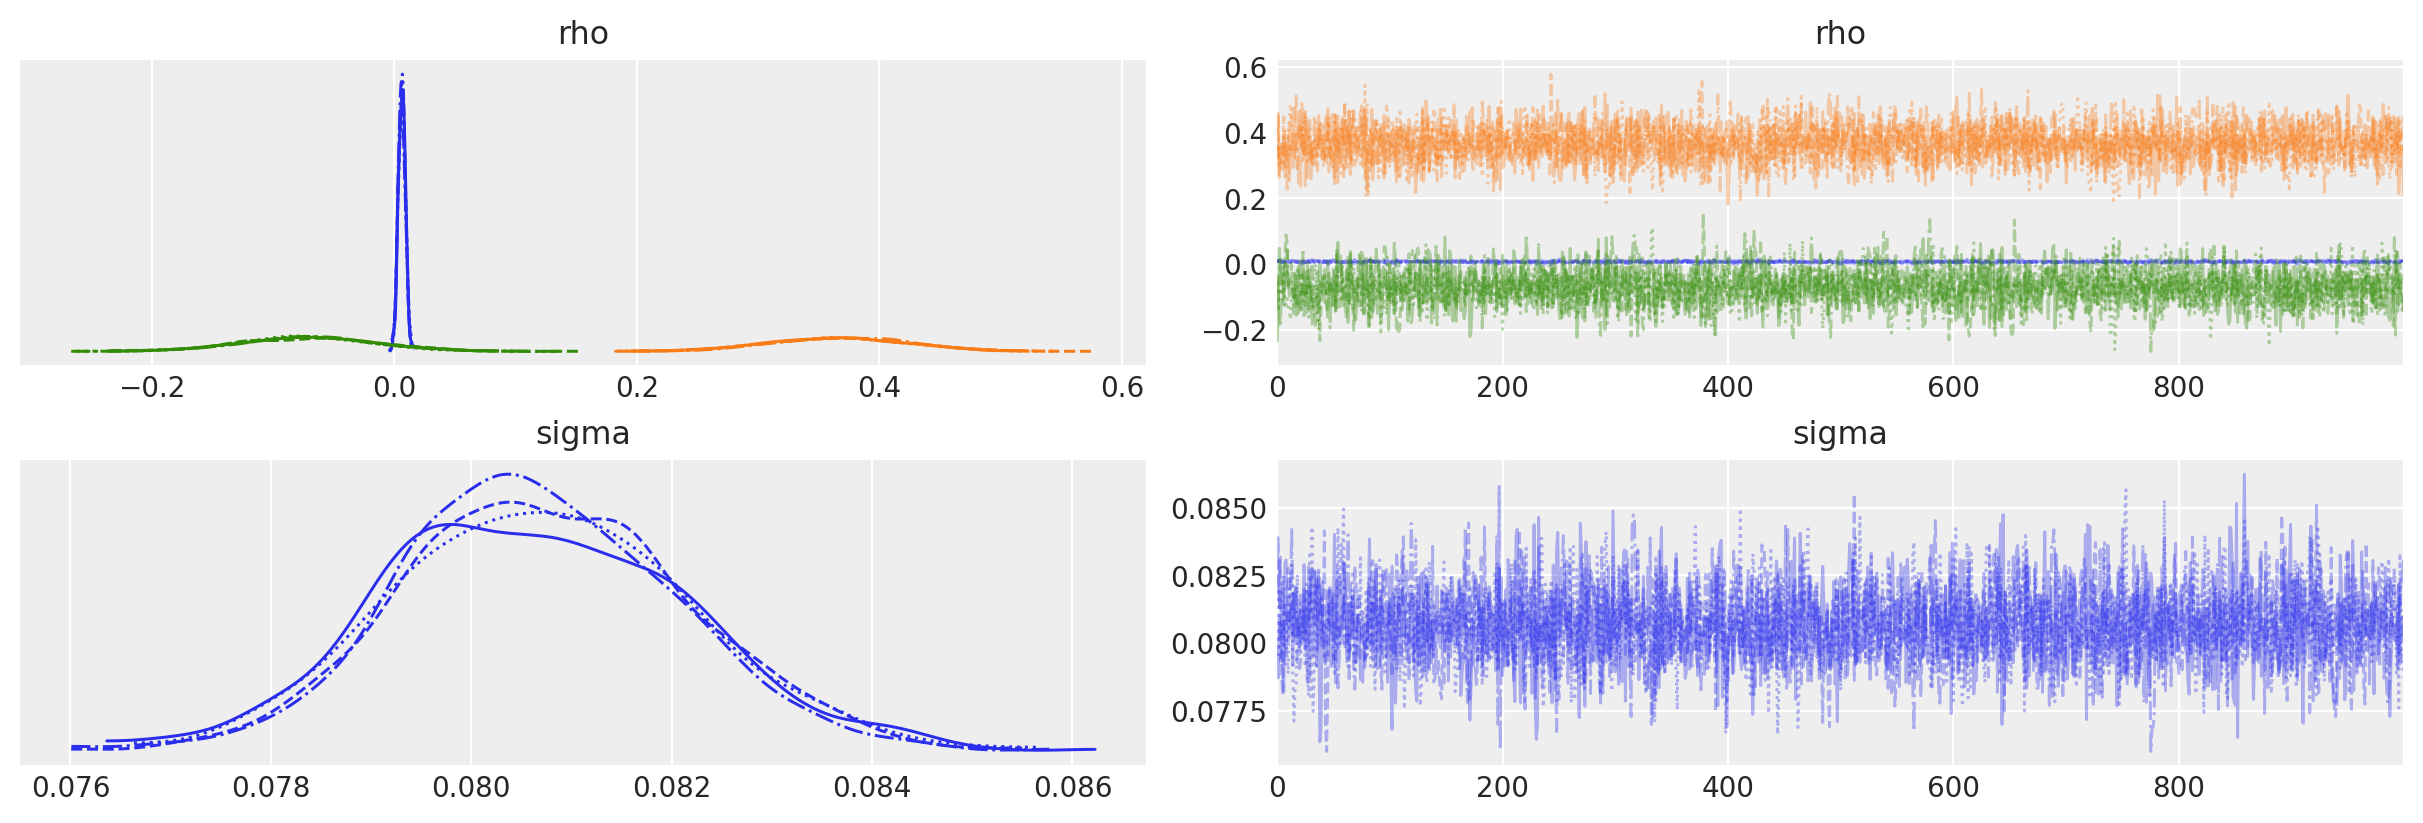

In [103]:
# AR(2) with constant
y = GDP_25_growth.T

with pm.Model() as ar2wc:
    rho = pm.Normal("rho", 0.0, 1.0, shape=3)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "ar2wc", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata_ar2wc = pm.sample(
        1000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
    )

    idata_ar2wc.extend(pm.compute_log_likelihood(idata_ar2wc)) # calcule la log_likelihood pour chaque chain x draw x série (ar_dim_0)
    
az.plot_trace(
    idata_ar2wc
);

In [104]:
# Stats des coefs
az.summary(idata_ar2wc)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
rho[0]  0.006  0.003   0.001    0.012      0.000    0.000    2972.0    2879.0   
rho[1]  0.366  0.056   0.268    0.478      0.001    0.001    3213.0    3035.0   
rho[2] -0.071  0.055  -0.176    0.033      0.001    0.001    3308.0    2641.0   
sigma   0.081  0.001   0.078    0.083      0.000    0.000    3574.0    2750.0   

        r_hat  
rho[0]    1.0  
rho[1]    1.0  
rho[2]    1.0  
sigma     1.0

In [105]:
# Log_likelihood sommée sur les 71 séries, moyenne entre les 4 x 1000 tirages
idata_ar2wc.log_likelihood.ar2wc.sum(["ar2wc_dim_0"]).mean(["chain","draw"]).values

array(1259.06002729)

Based on the previous results, we get the following ovservations : 
- The coefficients for the $AR(2)$ with constant and $AR(2)$ without constant are very variant so the model is not satisfying 
- Both the $AR(1)$ with and without constant are reliable models, with coefficients that do not vary much and similar log-likelihood. 

Hence, we choose the model $AR(1)$ no constant. 

## II. 2. Estimation of AR(1) without constant with ignorance structure

In [43]:
def initialize_model_ar(y, K, e0=1.0):
    """
    Initialise les paramètres du modèle.
    y: Liste des séries temporelles [N x T]
    K: Nombre de groupes
    e0: Hyperparamètre du Dirichlet
    """
    N,T = y.shape
    eta = dirichlet.rvs([e0] * K, size=1).flatten()  # Dirichlet prior for eta
    S = np.random.choice(K, size=N)  # Random initial classification
    theta = [np.random.randn(1) for _ in range(K)]  # Paramètre pour chaque groupe theta_k
    sigma = [np.abs(np.random.normal(loc=0, scale=3)) for _ in range(K)] # Prior de sigma = halfnormal

    return eta, S, theta, sigma

In [44]:
def ar_log_likelihood(yi, thetak, sigmak):
    """
    Calcule la vraisemblance logarithmique d'un modèle AR(1) sans constante
    theta, sigma2 : paramètres AR
    yi : série temporelle
    """
    T = len(yi)

    theta = thetak
    sigma2 = sigmak**2
    
    # Log-vraisemblance pour y2, ..., yT
    residuals = yi.iloc[1:] - (theta * yi.iloc[:-1])
    ll = -0.5 * (T-1) * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(residuals**2 / sigma2)
    
    return ll

In [45]:
def sample_S_ar(y, theta, sigma, eta, K):
    """
    Échantillonne les indicateurs de groupe S.
    y : séries temporelles
    theta / sigma : paramètres AR pour chaque groupe
    eta : probabilités de groupe
    """
    N,T = y.shape

    log_probs = np.zeros((N, K))
    
    for k in range(K):
        for i in range(N):
            log_probs[i, k] = np.log(eta[k]) + ar_log_likelihood(y.iloc[i,:], theta[k], sigma[k])
    
    # Normalisation pour obtenir des probabilités
    probs = np.exp(log_probs - log_probs.max(axis=1, keepdims=True))
    probs /= probs.sum(axis=1, keepdims=True)

    # Échantillonnage des groupes
    S = np.array([np.random.choice(K, p=probs[i]) for i in range(N)])
    return S

In [46]:
def estimate_ar_params(y):
    """
    Estime les paramètres AR(1) sans constante pour un ensemble de séries.
    """
    # ATTENTION : il faut s'assurer que les pays sont bien en ligne (NxT) 
    # Et qu'il n'y a pas d'autres variables dans le df

    with pm.Model() as ar1nc:
        rho = pm.Normal("rho", 0.0, 1.0, shape=1)
        sigma = pm.HalfNormal("sigma", sigma=3)
        likelihood = pm.AR(
            "ar1nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
        ) # NB : sigma correspond à la standard deviation et pas la variance (=sigma**2)

        idata_ar1nc = pm.sample(
            500,
            tune=500,
            chains=2,
            target_accept=0.9,
            random_seed=RANDOM_SEED,
            progressbar=False,
        )
       
    # Valeur moyenne des coefficients
    theta = az.summary(idata_ar1nc).iloc[0,0]
    sigma = az.summary(idata_ar1nc).iloc[1,0]
    
    return theta,sigma

def update_theta_ar(y, S, K):
    """
    Met à jour les paramètres AR pour chaque groupe.
    """
    theta = []
    sigma = []
    for k in range(K):
        group_data = y[S == k]  # Séries assignées au groupe k
        # ATTENTION : il faut vérifier à quoi ressemble "group_data" => pays bien en ligne ? Pas de colonne parasite ? (ex S)
        theta_k,sigma_k = estimate_ar_params(group_data)
        theta.append(theta_k)
        sigma.append(sigma_k)

    return theta,sigma

In [47]:
def update_eta_ignorance_structure(S, K, e0=1.0):
    """
    Met à jour les probabilités a priori des paramètres eta (structure d'ignorance) influencées  par la distribution actuelle des affectations S.
    """
    counts = np.bincount(S, minlength=K) + e0  # Comptes augmentés par le prior (nombre d'observations assignées à chaque groupe k + e0)
    return dirichlet.rvs(counts, size=1).flatten()

In [65]:
def mcmc_ar(y, K, num_iterations, e0=1.0):
    """
    Exécute une chaîne MCMC pour estimer les paramètres du modèle AR(1) sans constante avec structure d'ignorance pour eta.
    y : séries temporelles (array [N x T])
    K : nombre de groupes
    num_iterations : nombre d'itérations de MCMC
    e0 : hyperparamètre de la distribution Dirichlet pour eta
    """

    all_params = {"eta": [], "S": [], "theta": [], "sigma": []}

    
    # Initialisation des paramètres
    eta, S, theta, sigma = initialize_model_ar(y, K, e0)

    for iter in range(num_iterations):
        # Étape (a) : Échantillonnage des groupes S
        S = sample_S_ar(y, theta, sigma, eta, K)

        # Étape (b.1) : Mise à jour des paramètres AR pour chaque groupe
        theta,sigma = update_theta_ar(y, S, K)

        # Étape (b.2) : Mise à jour des probabilités de groupe eta
        eta = update_eta_ignorance_structure(S, K, e0)

        # Sauvegarde des paramètres à chaque itération
        all_params["eta"].append(eta.copy())
        all_params["S"].append(S.copy())
        all_params["theta"].append(theta.copy())
        all_params["sigma"].append(sigma.copy())
 
    return all_params


In [68]:
y=GDP_25_growth.T
K=2
num_iterations=500

In [ ]:
all_params=mcmc_ar(y,K,num_iterations)

In [ ]:
# Save with pickle
with open("all_params_K2.pkl", "wb") as f:
    pickle.dump(all_params_K2, f)

In [ ]:
# Load with pickle
with open("all_params_K2.pkl", "rb") as f:
    all_params_K2 = pickle.load(f)


## II. 3. Estimation of AR(1) without constant with logit structure

Here, we need to specify an exogeneous variable z for the logit structure. For this, we consider the population size. More specifically, to fit the parameters' size, we can choose either the mean population over all time periods, or the population size of one of the last time periods. 

In [27]:
z_last = pop_yearly_30_growth.iloc[-3]
z_last.head(3)

Argentina    0.987534
Australia    0.925521
Austria      0.924029
Name: 2022.0, dtype: float64

In [28]:
z_mean = pop_yearly_30_growth.mean(axis=0)
z_mean.head(4)

Argentina    0.563324
Australia    0.466248
Austria      0.410334
Belgium      0.450587
dtype: float64

In [29]:
def initialize_model_ar_logit(y, z, K):
    """
    Initialise les paramètres du modèle.
    y: Liste des séries temporelles [N x T]
    z: variable exogène pour le modèle logit
    K: Nombre de groupes
    """

    N, T = y.shape
    S = np.random.choice(K, size=N)  # Initial random group assignments
    theta = [np.random.randn(1) for _ in range(K)]  # Paramètre pour chaque groupe theta_k
    sigma = [np.abs(np.random.normal(loc=0, scale=3)) for _ in range(K)] # Prior de sigma = halfnormal
    gamma = np.random.normal(0, 1, size=(K - 1, N+1))  # Logit coefficients
    return S, theta, sigma, gamma


In [30]:
def ar_log_likelihood(yi, thetak, sigmak):
    """
    Calcule la vraisemblance logarithmique d'un modèle AR(1) sans constante
    theta, sigma2 : paramètres AR
    yi : série temporelle
    """
    T = len(yi)

    theta = thetak
    sigma2 = sigmak**2
    
    # Log-vraisemblance pour y2, ..., yT
    residuals = yi.iloc[1:] - (theta * yi.iloc[:-1])
    ll = -0.5 * (T-1) * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(residuals**2 / sigma2)
    
    return ll

In [31]:
def sample_S_ar_logit(y, z, theta, sigma, gamma, K):
    """
    Échantillonne les indicateurs de groupe S.
    y : séries temporelles
    z: variable exogène du logit
    theta / sigma : paramètres AR pour chaque groupe
    gamma : probabilités de groupe
    K: nb de clusters
    """

    N,T = y.shape

    S = np.zeros(N, dtype=int)
    for i in range(N):
        probs = []
        for k in range(K):
            z_with_intercept = np.append(z[i], 1)  # Add intercept term
            logit_prob = np.exp(z_with_intercept @ gamma[k - 1]) if k > 0 else 1
            likelihood = ar_log_likelihood(y.iloc[i,:], theta[k], sigma[k])
            probs.append(likelihood * logit_prob)
        probs = np.array(probs) / np.sum(probs)
        S[i] = np.random.choice(K, p=probs)
    return S


In [32]:
def estimate_ar_params(y):
    """
    Estime les paramètres AR(1) sans constante pour un ensemble de séries.
    """
    # ATTENTION : il faut s'assurer que les pays sont bien en ligne (NxT) 
    # Et qu'il n'y a pas d'autres variables dans le df

    with pm.Model() as ar1nc:
        rho = pm.Normal("rho", 0.0, 1.0, shape=1)
        sigma = pm.HalfNormal("sigma", sigma=3)
        likelihood = pm.AR(
            "ar1nc", rho=rho, sigma=sigma, constant=False, init_dist=pm.Normal.dist(0, 10), observed=y
        ) # NB : sigma correspond à la standard deviation et pas la variance (=sigma**2)

        idata_ar1nc = pm.sample(
            500,
            tune=500,
            chains=2,
            target_accept=0.9,
            random_seed=RANDOM_SEED,
            progressbar=False,
        )
       
    # Valeur moyenne des coefficients
    theta = az.summary(idata_ar1nc).iloc[0,0]
    sigma = az.summary(idata_ar1nc).iloc[1,0]
    
    return theta,sigma

In [33]:
def update_theta_ar_logit(y, S, K):
    """
    Met à jour les paramètres AR pour chaque groupe.
    """
    theta = []
    sigma = []
    for k in range(K):
        group_data = y[S == k]  # Séries assignées au groupe k
        # ATTENTION : il faut vérifier à quoi ressemble "group_data" => pays bien en ligne ? Pas de colonne parasite ? (ex S)
        theta_k,sigma_k = estimate_ar_params(group_data)
        theta.append(theta_k)
        sigma.append(sigma_k)

    return theta,sigma

In [34]:
def update_gamma_ar_logit(S, z, gamma, mu_gamma=0, sigma_gamma=1, step_size=0.1):
    K= len(gamma)
    gamma_new = gamma.copy()
    for k in range(K):
        gamma_proposal = gamma[k] + np.random.normal(0, step_size, size=d)
        log_prior_current = -0.5 * np.sum((gamma[k] - mu_gamma) ** 2) / sigma_gamma**2
        log_prior_proposal = -0.5 * np.sum((gamma_proposal - mu_gamma) ** 2) / sigma_gamma**2

        log_likelihood_current = 0
        log_likelihood_proposal = 0
        for i in range(len(S)):
            z_with_intercept = np.append(z[i], 1)  # Add intercept for logit model
            
            logit_prob_current = np.exp(z_with_intercept @ gamma[k]) / (1 + np.exp(z_with_intercept @ gamma[k]))
            logit_prob_proposal = np.exp(z_with_intercept @ gamma_proposal) / (1 + np.exp(z_with_intercept @ gamma_proposal))
            log_likelihood_current += S[i] * np.log(logit_prob_current)
            log_likelihood_proposal += S[i] * np.log(logit_prob_proposal)

        log_acceptance_ratio = (log_prior_proposal + log_likelihood_proposal) - (
            log_prior_current + log_likelihood_current
        )

        if np.log(np.random.rand()) < log_acceptance_ratio:
            gamma_new[k] = gamma_proposal
    return gamma_new


In [35]:
def mcmc_ar_logit(y, z, K, num_iterations):
    """
    Exécute une chaîne MCMC pour estimer les paramètres du modèle AR(1) avec constante avec structure logit pour S.
    y: Liste des séries temporelles [N x T]
    z: variable exogène pour le modèle logit
    K: Nombre de groupes
    num_iterations : nombre d'itérations de MCMC
    """
    
    # Initialisation des paramètres
    S, theta, sigma, gamma = initialize_model_ar_logit(y, z, K)

    for iter in range(num_iterations):
        # Étape (a) : Échantillonnage des groupes S
        S = sample_S_ar_logit(y, z, theta, sigma, gamma, K)

        # Étape (b.1) : Mise à jour des paramètres AR pour chaque groupe
        theta,sigma = update_theta_ar_logit(y, S, K)

        # Étape (b.2) : Mise à jour des probabilités de groupe eta
        gamma = updata_gamma_ar_logit(S, z, gamma, mu_gamma=0, sigma_gamma=1, step_size=0.1)
        
        # Diagnostics ou suivi des progrès
        if iter % 100 == 0:
            print(f"Iteration {iter}: eta = {eta}")

    return S, theta, sigma, gamma


In [222]:
y=GDP_25_growth.T
z=z_last.T
K=2
num_iterations=5

In [223]:
S,theta,sigma,gamma = mcmc_ar_logit(y,z,K,num_iterations)

/var/folders/p2/mz39_3ld1931_8d18wv6l6jh0000gn/T/ipykernel_41020/2089868946.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  z_with_intercept = np.append(z[i], 1)  # Add intercept term


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 72 is different from 2)

## III. Estimate the optimal number of clusters K

To do so, we use the bridge samplijg algorithm, coupled with a uniform prior for $M_k$ : $Pr(M_K)= 1/K_{max}$
 

In [156]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet, norm

In [157]:
def prior_density(theta, sigma, eta):
    log_prior = 0
    for k in range(len(eta)):
        alpha, beta = theta[k]
        log_prior += norm.logpdf(alpha, loc=0, scale=10)
        log_prior += norm.logpdf(beta, loc=0, scale=10)
        log_prior += pm.Halfnorm.logpdf(sigma[k], scale=3)
    log_prior += dirichlet.logpdf(eta, alpha=[1.0] * len(eta))
    return np.exp(log_prior)

In [158]:
# Fonction de bridge sampling
def bridge_sampling(y, theta_samples, proposal_samples, likelihood_fn, prior_fn):
    """
    Applique le bridge sampling pour estimer la vraisemblance marginale.
    """
    N1 = len(proposal_samples)
    N2 = len(theta_samples)
    
    s1 = N1 / (N1 + N2)
    s2 = N2 / (N1 + N2)
    
    p_y = 1.0  # Initial guess for marginal likelihood
    tolerance = 1e-6
    max_iter = 100
    
    for _ in range(max_iter):
        numerator = 0
        denominator = 0
        
        for theta in proposal_samples:
            numerator += likelihood_fn(y, theta) * prior_fn(theta) / (s1 * likelihood_fn(y, theta) * prior_fn(theta) + s2 * p_y)
        numerator /= N1
        
        for theta in theta_samples:
            denominator += 1 / (s1 * likelihood_fn(y, theta) * prior_fn(theta) + s2 * p_y)
        denominator /= N2
        
        new_p_y = numerator / denominator
        if np.abs(new_p_y - p_y) < tolerance:
            break
        p_y = new_p_y
    
    return p_y

## III. 1. Bridge sampling for ignorance structure

In [159]:
# Algorithme MCMC avec choix du nombre optimal de clusters
def mcmc_ar_bridge(y, K_max, num_iterations, e0=1.0):
    """
    Exécute une chaîne MCMC pour estimer les paramètres et le nombre optimal de clusters.
    """
    N, T = y.shape
    marginal_likelihoods = []
    results = {}
    
    for K in range(1, K_max + 1):
        eta, S, theta, sigma = initialize_model_ar(y, K, e0)
        all_params = {"eta": [], "S": [], "theta": [], "sigma": []}

        for _ in range(num_iterations):
            S = sample_S_ar(y, theta, sigma, eta, K)
            theta, sigma = update_theta_ar(y, S, K)
            eta = update_eta_ignorance_structure(S, K, e0)

            # Sauvegarde des paramètres à chaque itération
            all_params["eta"].append(eta.copy())
            all_params["S"].append(S.copy())
            all_params["theta"].append(theta.copy())
            all_params["sigma"].append(sigma.copy())
        
        # Calcul de la vraisemblance marginale via bridge sampling
        proposal_samples = [np.random.randn(2) for _ in range(100)]  # Échantillons de la distribution de proposition
        marginal_likelihood = bridge_sampling(
            y,
            theta,
            proposal_samples,
            lambda y, theta: np.exp(ar_log_likelihood(y, theta, sigma)),
            lambda theta: prior_density(theta, sigma, eta)
        )
        marginal_likelihoods.append(marginal_likelihood)

        # Sauvegarde des résultats pour ce K
        results[K] = {"marginal_likelihood": marginal_likelihood, "parameters": all_params}

    
    # Choix du K optimal
    best_K = np.argmax(marginal_likelihoods) + 1

    return best_K, results

## III. 2. Bridge sampling for logit structure

In [173]:
# Algorithme MCMC avec choix du nombre optimal de clusters
def mcmc_ar_bridge_logit(y,z, K_max, num_iterations, e0=1.0):
    """
    Exécute une chaîne MCMC pour estimer les paramètres et le nombre optimal de clusters en structure logit
    """
    N, T = y.shape
    marginal_likelihoods = []
    results = {}
    
    for K in tqdm(range(1, K_max + 1)):
        S, theta, sigma,gamma = initialize_model_ar_logit(y,z, K)
        all_params = {"gamma": [], "S": [], "theta": [], "sigma": []}

        for _ in range(num_iterations):
            S = sample_S_ar_logit(y,z, theta, sigma, gamma, K)
            theta, sigma = update_theta_ar_logit(y, S, K)
            gamma = update_gamma_ar_logit(S,z,gamma, 0, 1)

            # Sauvegarde des paramètres à chaque itération
            all_params["gamma"].append(gamma.copy())
            all_params["S"].append(S.copy())
            all_params["theta"].append(theta.copy())
            all_params["sigma"].append(sigma.copy())
        
        # Calcul de la vraisemblance marginale via bridge sampling
        proposal_samples = [np.random.randn(2) for _ in range(100)]  # Échantillons de la distribution de proposition
        marginal_likelihood = bridge_sampling(
            y,
            theta,
            proposal_samples,
            lambda y, theta: np.exp(ar_log_likelihood(y, theta, sigma)),
            lambda theta: prior_density(theta, sigma, gamma)
        )
        marginal_likelihoods.append(marginal_likelihood)

        # Sauvegarde des résultats pour ce K
        results[K] = {"marginal_likelihood": marginal_likelihood, "parameters": all_params}

    
    # Choix du K optimal
    best_K = np.argmax(marginal_likelihoods) + 1

    return best_K, results

### Test on simulated data

In [47]:
# Simuler des données pour le test
def simulate_data(N, T, K, true_theta, true_sigma):
    """
    Simule des séries temporelles pour N individus avec T observations,
    appartenant à K clusters définis par true_theta et true_sigma.
    """
    y = np.zeros((N, T))
    true_S = np.random.choice(K, size=N)  # Attribution aléatoire des clusters
    for i in range(N):
        cluster = true_S[i]
        alpha, beta = true_theta[cluster]
        sigma = true_sigma[cluster]
        y[i, 0] = np.random.normal(loc=0, scale=sigma)  # Initialisation
        for t in range(1, T):
            y[i, t] = alpha + beta * y[i, t-1] + np.random.normal(loc=0, scale=sigma)
    return y, true_S

# Paramètres pour la simulation
N = 50  # Nombre de séries temporelles
T = 20  # Longueur des séries temporelles
K_true = 3  # Nombre réel de clusters
true_theta = [(0.5, 0.8), (-0.5, 0.6), (1.0, 0.3)]  # (alpha_k, beta_k) pour chaque cluster
true_sigma = [0.5, 0.3, 0.7]  # sigma_k pour chaque cluster

# Générer des données simulées
y, true_S = simulate_data(N, T, K_true, true_theta, true_sigma)

In [161]:
y = GDP_25_growth
z = z_last

In [162]:
# Tester l'algorithme MCMC avec bridge sampling ignorance
K_max = 5  # Nombre maximum de clusters à tester
num_iterations = 10  # Petit nombre d'itérations pour le test rapide

# Appeler la fonction mcmc_ar_bridge
best_K, marginal_likelihoods, parameters_by_K = mcmc_ar_bridge(y, K_max, num_iterations)

# Résultats
print(f"Nombre de clusters optimal estimé : {best_K}")
print("Vraisemblance marginale pour chaque K :")
for K, likelihood in enumerate(marginal_likelihoods, 1):
    print(f"K={K}, marginal likelihood={likelihood:.4f}")
print("\nParamètres estimés pour K optimal :")
print(parameters_by_K[best_K])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sa

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [174]:
# Tester l'algorithme MCMC avec bridge sampling logit
K_max = 5  # Nombre maximum de clusters à tester
num_iterations = 10  # Petit nombre d'itérations pour le test rapide

# Appeler la fonction mcmc_ar_bridge
best_K, marginal_likelihoods, parameters_by_K = mcmc_ar_bridge_logit(y,z, K_max, num_iterations)

# Résultats
print(f"Nombre de clusters optimal estimé : {best_K}")
print("Vraisemblance marginale pour chaque K :")
for K, likelihood in enumerate(marginal_likelihoods, 1):
    print(f"K={K}, marginal likelihood={likelihood:.4f}")
print("\nParamètres estimés pour K optimal :")
print(parameters_by_K[best_K])

  0%|          | 0/5 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rho, sigma]
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergen

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'